Avant de commencer : <br>
`conda install graphviz`

La progression du cours d'aujourd'hui :
- On commence par un peu de manipulation. Le but est d'amener une intuition qui sous-tend la méthode statistique du Bootstrap.
- On prend le temps de formaliser un peu tout cela par un peu de cours, on pose des bases rigoureuses à ce qu'est le Bootstrap, ce qui nous permet d'introduire le méta-algorithme du Bagging.
- On revient au notebook pour implémenter un Bagging d'arbres de classification.
- On pousse l'idée du Bagging à son extrême en introduisant les Forets Aléatoires (Random Forests) dans un petit bout de cours théorie.
- Enfin on remet les mains dans la mécanique de scikit-learn en utilisant la classe `RandomForestsClassifier`.

On commence par les imports classiques.

In [1]:
import numpy as np
from sklearn import datasets
from sklearn import tree
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import shuffle
from sklearn.utils import resample
%matplotlib inline
import matplotlib.pyplot as plt

## Bootstrap, l'intuition

In [2]:
x=[2.,2.,2.,2.,5.]

<div class="alert alert-warning">On nous informe que les éléments de $x$ ont tous été tirés selon la même distribution de probabilité. Quelle est l'espérance de cette distribution ?</div>
Réponse pas si évidente que ça en fin de compte !

Les remarques clés et le raisonnement derrière la méthode du Bootstrap sont les suivantes :
<ol>
<li> Il s'agit en premier lieu de bien voir que la moyenne empirique $\hat{\theta}=\frac{1}{N}\sum_{i=1}^N x_i$ est un *estimateur* de la statistique $\theta = \mathbb{E}_{P_X}(X)$.
<li> Or cet estimateur est sensible au bruit, c'est-à-dire à la distribution $P_X$ elle-même.
<li> Cet estimateur converge vers la valeur de $\theta$ lorsque $N\rightarrow\infty$, donc si l'on était capables de tirer plus d'échantillons de $P_X$ on réduirait la variance de l'estimation $\hat{\theta}$.
<li> Seulement voilà, on n'a que les 5 échantillons de $x$ et pas plus.
<li> L'idée lumineuse consiste à tirer sur nos propres chausses pour gagner en hauteur, c'est-à-dire, moins poétiquement, à simuler $P_X$ en tirant aléatoirement des échantillons dans $x$. Cela consiste à simuler $F_x$ (notez le petit $x$), la fonction de répartition de la distribution empirique discrète correspondant à $x$.
<li> Alors, à chaque quintuplet de valeurs prises dans $x$ avec remise, on peut calculer $\hat{\theta}$ et la moyenne empirique de ces estimateurs simule l'estimateur $\hat{\theta}$ sur un nombre croissant d'échantillons, donc sa variance se réduit.
</ol>
<div class="alert alert-warning">Appliquons ce principe. Générez 100 échantillons de taille 5 d'éléments de $x$ et utilisez ces échantillons pour estimer l'espérance de la distribution $P_X$.</div>

In [11]:
##### REMOVE FOR STUDENTS
Nbootstrap = 100
theta = np.zeros(Nbootstrap)
for i in range(Nbootstrap):
    theta[i] = np.mean(np.random.choice(x,size=len(x),replace=True))
print("Moyenne empirique : %g"%(np.mean(x)))
print("Estimateur Bootstrap : %g"%(np.mean(theta)))

Moyenne empirique : 2.6
Estimateur Bootstrap : 2.576


Relancez plusieurs fois l'opération codé ci-dessus. Le bootstrap induit-il systématiquement un biais dans le même sens ?<br>
<br>
Prenons quelques minutes de cours pour bien voir ce qu'il y a derrière cette intuition de ré-échantillonage à partir de soi-même et pourquoi on l'appelle cette méthode le *Bootstrap*.

## Bagging
Reprenons l'exemple simulé du cours sur le Boosting et observons comment on peut implémenter une méthode de Bagging. Si vous aviez sauvé les données d'apprentissage et de test générées (`np.savetxt()` et `np.loadtxt()`), vous pouvez les recharger, sinon on peut en générer de nouvelles avec le code ci-dessous (recopié depuis le notebook sur le Boosting).

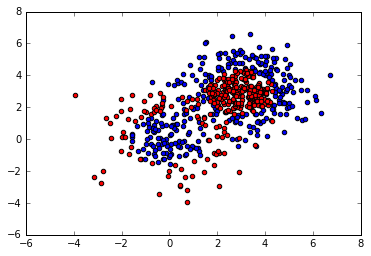

In [12]:
X1, y1 = datasets.make_gaussian_quantiles(cov=2.,
                                 n_samples=300, n_features=2,
                                 n_classes=2, random_state=1)
X2, y2 = datasets.make_gaussian_quantiles(mean=(3, 3), cov=1.5,
                                 n_samples=700, n_features=2,
                                 n_classes=2, random_state=1)
X = np.concatenate((X1, X2))
y = np.concatenate((y1, - y2 + 1))
y = 2*y-1

X, y = shuffle(X, y)

Xtest,X = np.split(X,[400])
ytest,y = np.split(y,[400])

Xblue = X[y==-1]
Xred = X[y==1]
plt.scatter(Xblue[:,0],Xblue[:,1],c='b')
_=plt.scatter(Xred[:,0],Xred[:,1],c='r')

On pourra ré-utiliser également les fonctions d'évaluation et d'affichage utilisées précédemment sur le même exemple.

In [13]:
def forest_predict(f,X):
    N = len(f)
    votes = np.zeros((X.shape[0],N))
    for i in range(N):
        votes[:,i] = f[i].predict(X)
    return np.sign(np.sum(votes,axis=1))

def forest_score(f,X,y):
    n=len(y)
    return np.sum(np.not_equal(forest_predict(f,X),y))/n

def plot_decision_boundary_forest(f, X, y):
    plot_step = 0.02
    x0_min, x0_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x1_min, x1_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx0, xx1 = np.meshgrid(np.arange(x0_min, x0_max, plot_step), np.arange(x1_min, x1_max, plot_step))
    yypred = forest_predict(f, np.c_[xx0.ravel(),xx1.ravel()])
    yypred = yypred.reshape(xx0.shape)
    plt.contourf(xx0, xx1, yypred, cmap=plt.cm.Paired)
    y_pred = forest_predict(f, X)
    Xblue_good = X[np.equal(y,-1)*np.equal(y,y_pred)]
    Xblue_bad  = X[np.equal(y,-1)*np.not_equal(y,y_pred)]
    Xred_good  = X[np.equal(y,1)*np.equal(y,y_pred)]
    Xred_bad   = X[np.equal(y,1)*np.not_equal(y,y_pred)]
    plt.scatter(Xblue_good[:,0],Xblue_good[:,1],c='b')
    plt.scatter(Xblue_bad[:,0],Xblue_bad[:,1],c='c',marker='v')
    plt.scatter(Xred_good[:,0],Xred_good[:,1],c='r')
    plt.scatter(Xred_bad[:,0],Xred_bad[:,1],c='m',marker='v')
    plt.show()

<div class="alert alert-warning">**A vous de jouer :** Implémentez un Bagging d'arbres de classification sur cet exemple.<br>
Estimez la variance de l'erreur d'apprentissage et celle de généralisation d'un classifieur "Arbre de décision"<br>
Tracez l'évolution de l'erreur d'apprentissage et celle de généralisation de la foret d'arbres construite, au fur et à mesure des itérations.</div>

Ecart-type de l'erreur d'apprentissage d'un arbre : 0.00791673
Ecart-type de l'erreur de généralisation d'un arbre : 0.0160071
Ecart-type de l'erreur de généralisation de la foret sur les 15 dernières itérations : 0.00449073
Moyenne de l'erreur de généralisation de la foret sur les 15 dernières itérations : 0.0955
Dernière erreur de généralisation de la forêt : 0.09


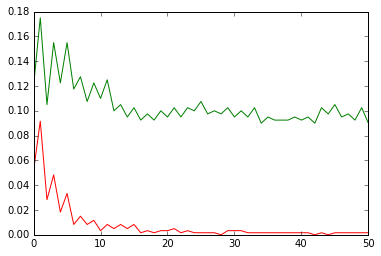

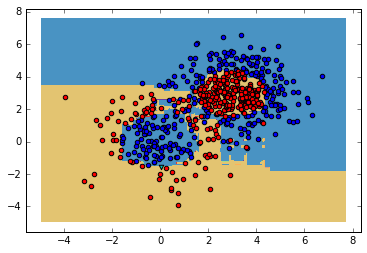

In [14]:
### REMOVE FOR STUDENTS
Nbootstrap = 51
forest = list()
tree_training_error = np.zeros(Nbootstrap)
tree_generalization_error = np.zeros(Nbootstrap)
forest_training_error = np.zeros(Nbootstrap)
forest_generalization_error = np.zeros(Nbootstrap)
for i in range(Nbootstrap):
    Xb, yb = resample(X, y)
    dt = tree.DecisionTreeClassifier(criterion='entropy')
    dt.fit(Xb,yb)
    forest.append(dt)
    # Eval
    tree_training_error[i]=1.-dt.score(X,y)
    tree_generalization_error[i] = 1.-dt.score(Xtest,ytest)
    forest_training_error[i]=forest_score(forest,X,y)
    forest_generalization_error[i]=forest_score(forest,Xtest,ytest)

print("Ecart-type de l'erreur d'apprentissage d'un arbre : %g"%np.std(tree_training_error))
print("Ecart-type de l'erreur de généralisation d'un arbre : %g"%np.std(tree_generalization_error))
print("Ecart-type de l'erreur de généralisation de la foret sur les 15 dernières itérations : %g"
      %np.std(forest_generalization_error[-15:]))
print("Moyenne de l'erreur de généralisation de la foret sur les 15 dernières itérations : %g"
      %np.mean(forest_generalization_error[-15:]))
print("Dernière erreur de généralisation de la forêt : %g"%forest_generalization_error[-1])
plt.plot(forest_training_error,c='r')
_=plt.plot(forest_generalization_error,c='g')
plt.figure()
plot_decision_boundary_forest(forest,X,y)

<div class="alert alert-warning">Fallait-il beaucoup d'arbres pour parvenir à une bonne erreur de généralisation ?<br>
Que dire du sur-apprentissage ?<br>
Comment ces résultats se comparent-ils au Boosting d'arbres en termes de stabilité de la solution et d'erreur de généralisation ?</div>

Scikit-learn fournit une méthode implémentant le méta-algorithme du Bagging.
<div class="alert alert-warning">Jetez un oeil à la [documentation](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html#sklearn.ensemble.BaggingClassifier), puis utilisez cette méthode pour reproduire l'exercice précédent.</div>

Erreur de généralisation : 0.085


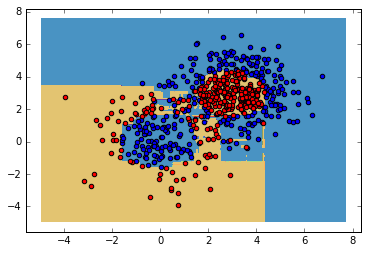

In [23]:
### REMOVE FOR STUDENTS
def plot_decision_boundary(f,X,y):
    plot_step = 0.02
    x0_min, x0_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x1_min, x1_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx0, xx1 = np.meshgrid(np.arange(x0_min, x0_max, plot_step), np.arange(x1_min, x1_max, plot_step))
    yypred = f.predict(np.c_[xx0.ravel(),xx1.ravel()])
    yypred = yypred.reshape(xx0.shape)
    plt.contourf(xx0, xx1, yypred, cmap=plt.cm.Paired)
    y_pred = f.predict(X)
    Xblue_good = X[np.equal(y,-1)*np.equal(y,y_pred)]
    Xblue_bad  = X[np.equal(y,-1)*np.not_equal(y,y_pred)]
    Xred_good  = X[np.equal(y,1)*np.equal(y,y_pred)]
    Xred_bad   = X[np.equal(y,1)*np.not_equal(y,y_pred)]
    plt.scatter(Xblue_good[:,0],Xblue_good[:,1],c='b')
    plt.scatter(Xblue_bad[:,0],Xblue_bad[:,1],c='c',marker='v')
    plt.scatter(Xred_good[:,0],Xred_good[:,1],c='r')
    plt.scatter(Xred_bad[:,0],Xred_bad[:,1],c='m',marker='v')
    plt.show()

bf = BaggingClassifier(tree.DecisionTreeClassifier(criterion='entropy'), n_estimators=51)
bf.fit(X,y)
print("Erreur de généralisation : %g"%(1.-bf.score(Xtest,ytest)))
plot_decision_boundary(bf,X,y)

## Random Forests
On arrive à la dernière méthode de ce notebook et à l'introduction d'une des méthodes des plus élégantes et les plus efficaces dans la littérature de Machine Learning. Les Forets Aléatoires (Random Forests) poussent l'idée du Bagging et de l'introduction de la variabilité dans les prédicteurs vers un extrême. Commençons par un peu de cours avant de mettre les mains dans le cambouis.<br>
Pour récapituler : Random Forests = Bagging sur arbres + sélection de features aléatoire + arbres complètement développés. Etonnament simple !
scikit-learn fournit une classe [RandomForestClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier). 
<div class="alert alert-warning">A vous de jouer pour appliquer une foret aléatoire sur le problème précédent.<br>
Prenez un peu de temps pour afficher l'importance de chaque descripteur (attribut `feature_importances_` de la classe RandomForestClassifier).<br>
Puis pourquoi ne reviendriez-vous pas sur un des problèmes des cours passés (Iris, MNIST ou Spam par exemple) pour essayer une forêt aléatoire ?
</div>

Erreur de généralisation : 0.0925


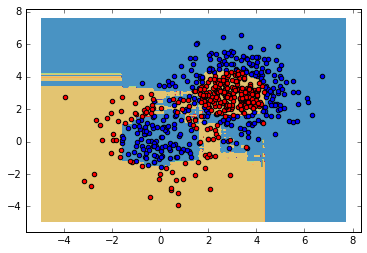

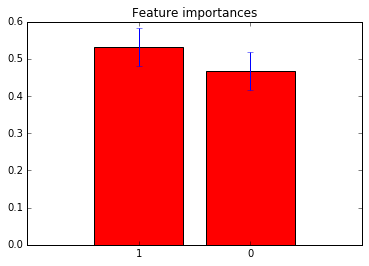

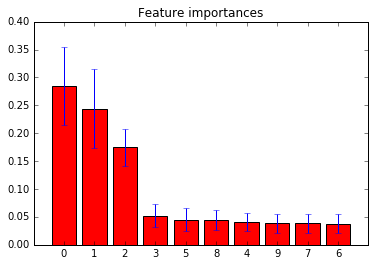

In [31]:
### REMOVE FOR STUDENTS
# Train forest
rf = RandomForestClassifier(n_estimators=51, criterion='entropy')
rf.fit(X,y)

# Plot
print("Erreur de généralisation : %g"%(1.-rf.score(Xtest,ytest)))
plot_decision_boundary(rf,X,y)

# Feature importance
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)
indices = np.argsort(importances)[::-1]
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

# A more demonstrative example
# Build a classification task using 3 informative features
X, y = datasets.make_classification(n_samples=1000,
                                    n_features=10,
                                    n_informative=3,
                                    n_redundant=0,
                                    n_repeated=0,
                                    n_classes=2,
                                    random_state=0,
                                    shuffle=False)
rf = RandomForestClassifier(n_estimators=51, criterion='entropy')
rf.fit(X,y)
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)
indices = np.argsort(importances)[::-1]
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()